In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, ViTTrainer
from src.vit_data import load_cell_cycle_data

model_dir = 'output/cell_cycle_24x128_2chan_p1_logfold_simple_20220819_319e'

vit, config = load_model_dir(model_dir, legacy=False)
vit_data = load_cell_cycle_data(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM)
config_name = "lfc"

dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG, 
                           valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)
print(dataloader.split_repr())

trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=model_dir)
trainer.setup()


Split: time,100; Training: 48697; Validation: 0; Testing: 4427


In [37]:
from src.rna_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()
trainer.orf_plotter = orf_plotter
trainer.rna_plotter = rna_plotter

In [117]:
from src.attention_analysis import AttentionAnalysis

a_analysis = AttentionAnalysis(trainer=trainer)

In [118]:
import cv2
from src.timer import Timer

timer = Timer()
att_size = trainer.collected_attentions.shape[-2], trainer.collected_attentions.shape[-1]

img_resize = cv2.resize(img, (att_size[1], att_size[0]))
imgs_resized = np.zeros_like(trainer.collected_attentions)

for i in range(len(vit_data.all_imgs)):
    cur_img = vit_data.all_imgs[i]
    for channel in range(cur_img.shape[0]):
        img_resize = cv2.resize(cur_img[channel], (att_size[1], att_size[0]))
        imgs_resized[i, channel] = img_resize
    timer.print_progress(i, len(vit_data.all_imgs), every=20000)


0/53124 - 00:00:00.03
20000/53124 - 00:00:01.14
40000/53124 - 00:00:02.26


In [120]:
from einops.layers.torch import Rearrange

vectorize_resize = Rearrange('b i (r) (c) -> b (i r c)')
resized_vectorized = vectorize_resize(torch.Tensor(imgs_resized)).numpy()


(53124, 96)

In [147]:
a_analysis.compute_umap(t=20, vector=resized_vectorized)

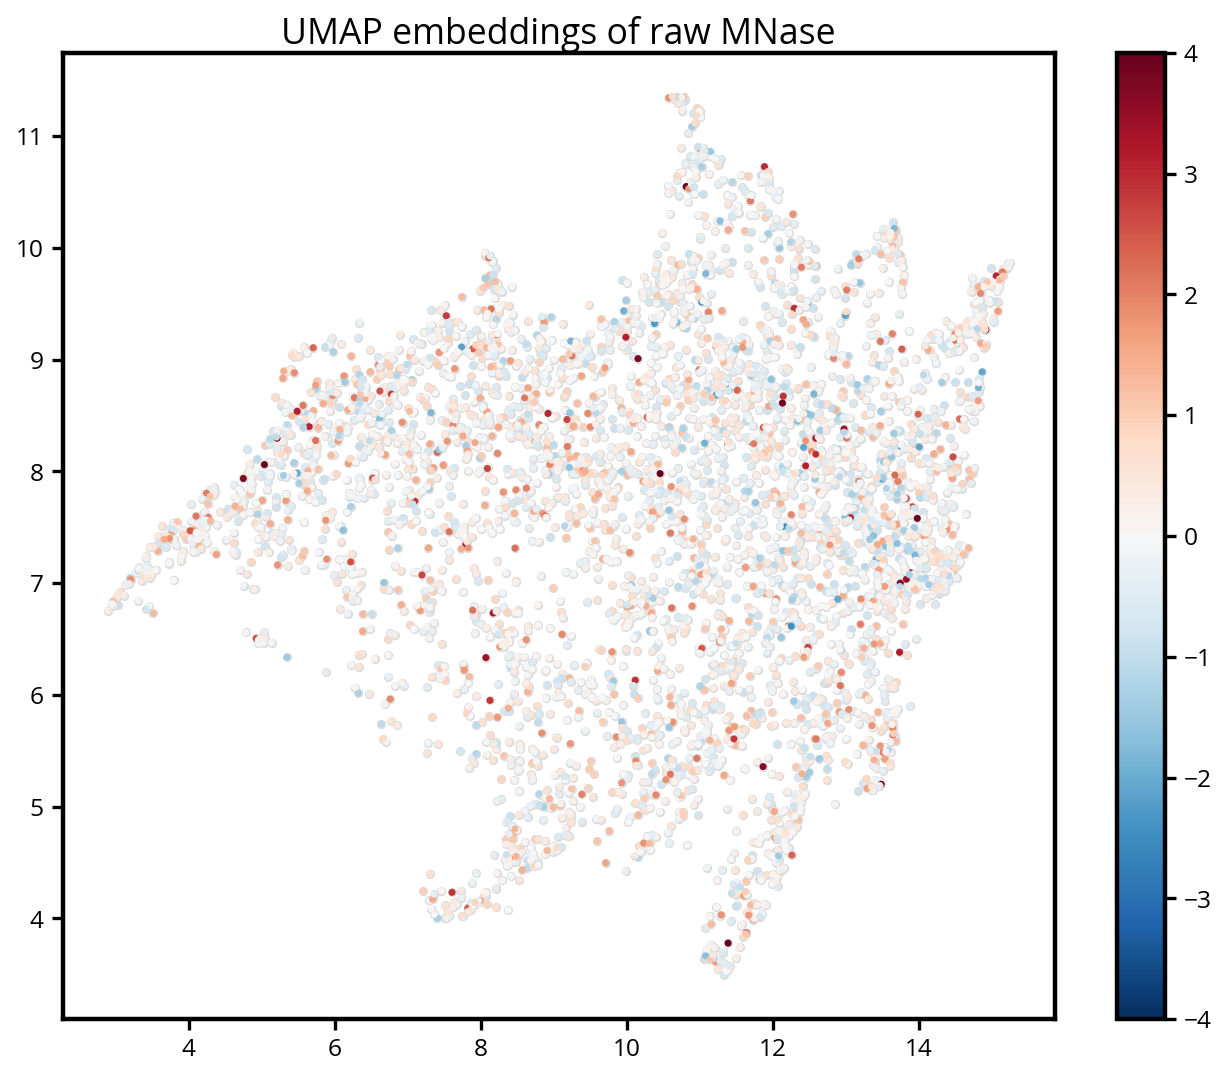

In [148]:
a_analysis.plot_umap(t=20, ascending=None, title="UMAP embeddings of raw MNase")

In [138]:
a_analysis.load_go_terms()

data/go.obo: fmt(1.2) rel(2018-08-29) 47,313 Terms


Term GO:0005625 not found!
Term GO:0004871 not found!
Term GO:0016563 not found!
Term GO:0001950 not found!
Term GO:0030528 not found!
Term GO:0005624 not found!
Term GO:0003709 not found!
Term GO:0000059 not found!
Term GO:0003704 not found!
Term GO:0007109 not found!
Term GO:0006608 not found!
Term GO:0006609 not found!
Term GO:0031015 not found!
Term GO:0000300 not found!
Term GO:0003701 not found!
Term GO:0010843 not found!
Term GO:0005792 not found!
Term GO:0016564 not found!
Term GO:0042991 not found!
Term GO:0003702 not found!
Term GO:0003716 not found!
Term GO:0016565 not found!
Term GO:0030818 not found!
Term GO:0007090 not found!
Term GO:0016944 not found!
Term GO:0000135 not found!
Term GO:0000115 not found!
Term GO:0000299 not found!
Term GO:0004702 not found!
Term GO:0000739 not found!
Term GO:0006200 not found!
Term GO:0004221 not found!
Term GO:0005057 not found!
Term GO:0016566 not found!
Term GO:0051436 not found!
Term GO:0000114 not found!
Term GO:0016585 not found!
T

In [149]:
go_orfs = a_analysis.go_orfs.copy()
go_orfs['n'] = a_analysis.go_orfs.orfs.map(len)
go_orfs

go_gene_max = 1000
go_gene_min = 20
go_lim_terms = go_orfs[(go_orfs.n >= go_gene_min) & (go_orfs.n <= go_gene_max)]

go_dispersions = a_analysis.compute_group_orfs_dispersion(go_lim_terms)


0/235 - 00:00:00.10
60/235 - 00:00:00.54
120/235 - 00:00:00.93
180/235 - 00:00:01.32


In [151]:
not_null = go_dispersions.index != 'Null'
go_dispersions.loc[not_null, 'description'] = a_analysis.go_orfs.loc[\
    go_dispersions.loc[not_null].index.values]['description']

cur_terms = go_dispersions[go_dispersions.n > 20]


dat = cur_terms.sort_values('entropy')[['n', 'entropy', 'description']].head(20)
dat['n'] = dat['n'].round(0)
dat['entropy'] = dat['entropy'].round(2)

print(dat)
print()


dat = cur_terms.sort_values('entropy')[['n', 'entropy', 'description']].tail(20)
dat['n'] = dat['n'].round(0)
dat['entropy'] = dat['entropy'].round(2)
print(dat)

dat.to_csv('entropy_lowest_raw.csv')

                 n  entropy                                        description
Null        1000.0  -175.65                                                NaN
GO:0003743    26.0  -175.48             Translation Initiation Factor Activity
GO:0005739   989.0  -171.27                                      Mitochondrion
GO:0005730   200.0  -163.99                                          Nucleolus
GO:0005840    96.0  -163.00                                           Ribosome
GO:0006289    27.0  -159.99                         Nucleotide-Excision Repair
GO:0005762    43.0  -158.10              Mitochondrial Large Ribosomal Subunit
GO:0032543    87.0  -158.04                          Mitochondrial Translation
GO:0005783   235.0  -156.79                              Endoplasmic Reticulum
GO:0016251    41.0  -154.76  Rna Polymerase Ii General Transcription Initia...
GO:0003735   213.0  -154.33                 Structural Constituent Of Ribosome
GO:0005768    63.0  -154.33                         

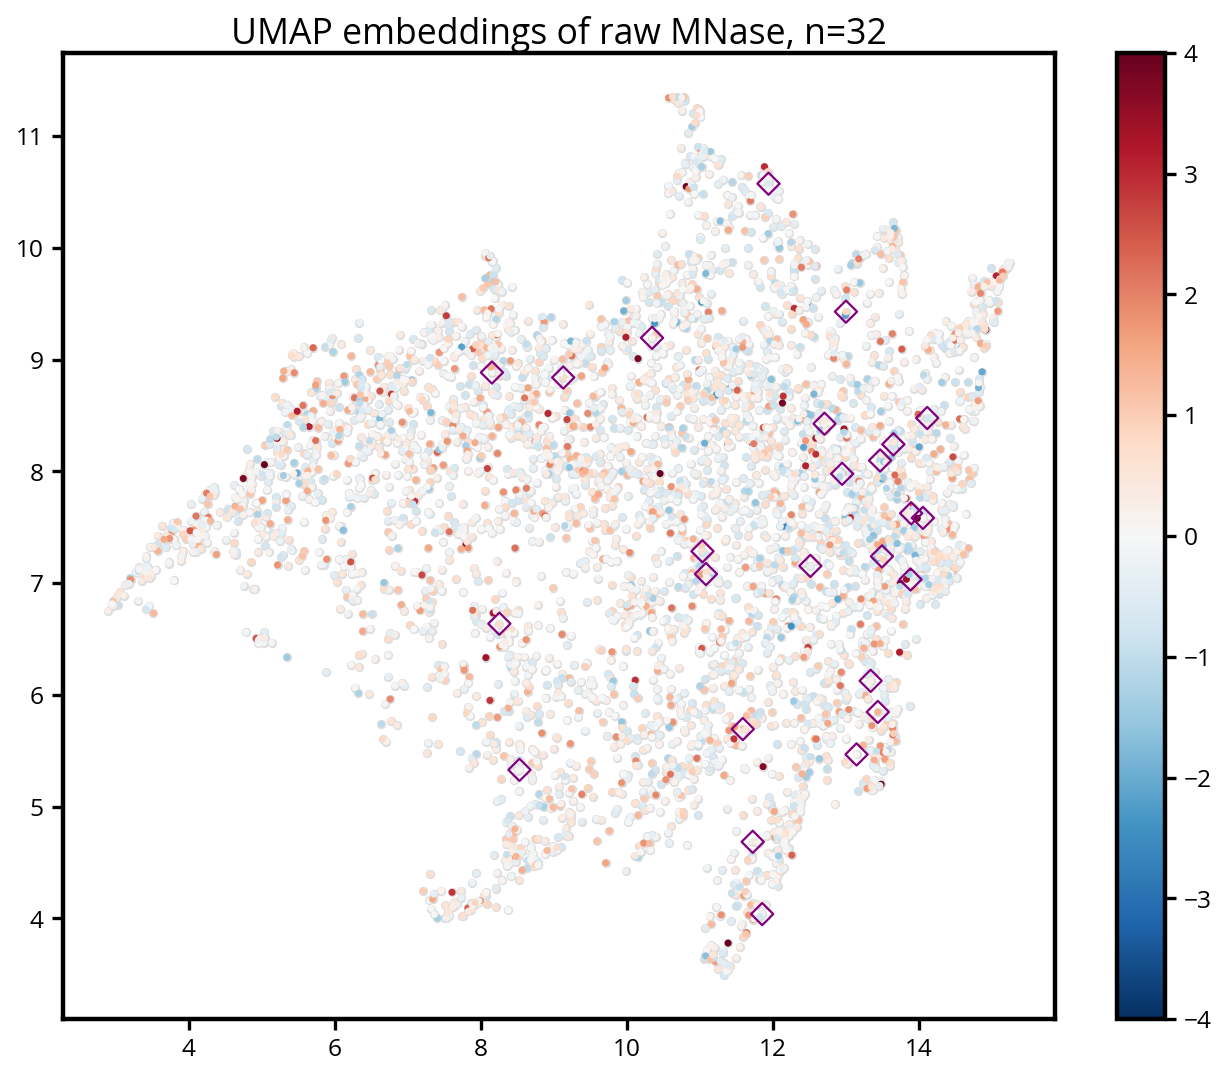

In [154]:
selected_orfs = a_analysis.go_orfs.loc['GO:0008361'].orfs

a_analysis.plot_umap(t=20, ascending=None, selected_orfs=selected_orfs, title="UMAP embeddings of raw MNase")

(array([ 2.,  1.,  2.,  1.,  7., 21., 22., 34., 27., 26., 29., 19., 12.,
        10.,  5.,  1.,  1.,  1.,  0.,  3.]),
 array([-175.64819834, -171.28929875, -166.93039917, -162.57149958,
        -158.21259999, -153.8537004 , -149.49480081, -145.13590122,
        -140.77700163, -136.41810205, -132.05920246, -127.70030287,
        -123.34140328, -118.98250369, -114.6236041 , -110.26470451,
        -105.90580493, -101.54690534,  -97.18800575,  -92.82910616,
         -88.47020657]),
 <BarContainer object of 20 artists>)

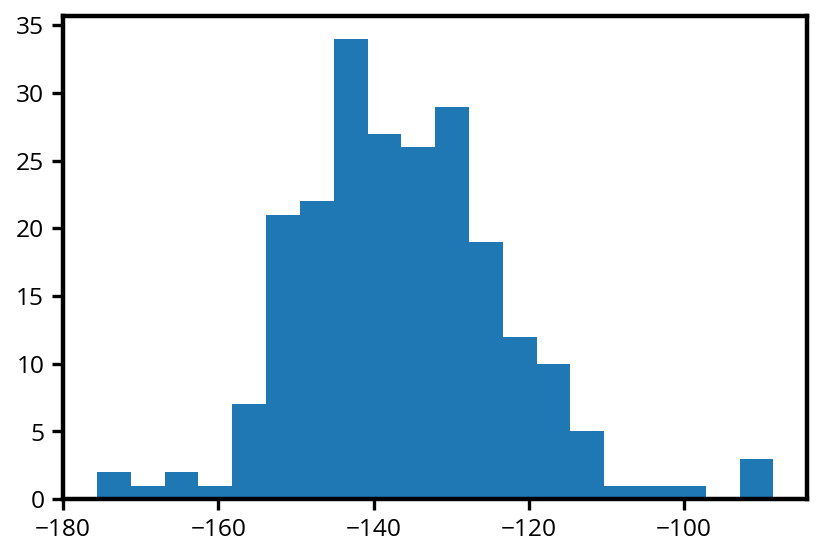

In [157]:
plt.hist(cur_terms['entropy'], bins=20)